# Сравнение опросов: v1 (март 2025) vs v2 (январь 2026)

Динамика изменений в использовании ИИ сотрудниками Mad Devs за ~10 месяцев.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')
PALETTE = sns.color_palette('Set2', 14)
sns.set_palette(PALETTE)

C_V1 = '#5DA5DA'
C_V2 = '#F15854'
C_PAIR = [C_V1, C_V2]

v1_raw = pd.read_csv('../Применение ИИ в работе (Responses) - старый.csv')
v2_raw = pd.read_csv('../Применение ИИ в работе v2 (Responses).csv')

SHORT_ROLES = {
    'Разработчик Backend и интегрированных систем': 'Backend',
    'Разработчик Frontend': 'Frontend',
    'DevOps': 'DevOps',
    'Другое': 'Другое',
    'Тимлид / Техлид': 'Тимлид/Техлид',
    'Инженер ML / Data Science': 'ML/DS',
    'Менеджер по поставкам (DM)': 'DM',
    'Прочий менеджмент': 'Менеджмент',
    'Менеджер проектов (PM)': 'PM',
    'QA': 'QA',
    'Design': 'Design',
    'Recruiting': 'Recruiting',
    'Разработчик Mobile': 'Mobile',
    'HR': 'HR',
}

SHORT_FREQ = {
    'Часто (каждый день)': 'Каждый день',
    'Постоянно (интегрировано в основной workflow, использую в IDE)': 'В IDE/workflow',
    'Запускаю ИИ в параллельном режиме для работы над несколькими задачами': 'Параллельный режим',
    'Иногда (3-4 раза в неделю)': 'Иногда',
    'Редко (1-2 раза в неделю)': 'Редко',
    'Никогда': 'Никогда',
}
FREQ_ORDER = ['Никогда', 'Редко', 'Иногда', 'Каждый день', 'В IDE/workflow', 'Параллельный режим']

SHORT_GRADES = {
    'Junior': 'Junior', 'Middle': 'Middle', 'Senior': 'Senior', 'Intern': 'Intern',
    'Не проходил грейдинг в компании': 'Без грейда',
    'Не применимо (для сотрудников отделов)': 'Н/Д (отдел)',
}
GRADE_ORDER = ['Intern', 'Junior', 'Middle', 'Senior', 'Без грейда', 'Н/Д (отдел)']

SHORT_POTENTIAL = {
    'ИИ станет использоваться значительно шире и чаще': 'Значительно шире',
    'ИИ станет критически важен': 'Критически важен',
    'Полная трансформация профессии': 'Полная трансформация',
    'Умеренный рост применения': 'Умеренный рост',
}
POTENTIAL_ORDER = ['Умеренный рост', 'Значительно шире', 'Критически важен', 'Полная трансформация']

v1 = v1_raw.copy()
v2 = v2_raw.copy()

v1['role'] = v1.iloc[:, 2].map(SHORT_ROLES).fillna(v1.iloc[:, 2])
v2['role'] = v2.iloc[:, 2].map(SHORT_ROLES).fillna(v2.iloc[:, 2])
v1['freq'] = v1.iloc[:, 4].map(SHORT_FREQ).fillna(v1.iloc[:, 4])
v2['freq'] = v2.iloc[:, 4].map(SHORT_FREQ).fillna(v2.iloc[:, 4])
v1['grade'] = v1.iloc[:, 3].map(SHORT_GRADES).fillna(v1.iloc[:, 3])
v2['grade'] = v2.iloc[:, 3].map(SHORT_GRADES).fillna(v2.iloc[:, 3])
v1['potential'] = v1.iloc[:, 16].map(SHORT_POTENTIAL).fillna(v1.iloc[:, 16])
v2['potential'] = v2.iloc[:, 19].map(SHORT_POTENTIAL).fillna(v2.iloc[:, 19])

v1['email'] = v1.iloc[:, 1].str.lower().str.strip()
v2['email'] = v2.iloc[:, 1].str.lower().str.strip()
overlap_emails = set(v1['email']) & set(v2['email'])

v1_overlap = v1[v1['email'].isin(overlap_emails)].drop_duplicates(subset='email', keep='last').copy()
v2_overlap = v2[v2['email'].isin(overlap_emails)].drop_duplicates(subset='email', keep='last').copy()


TOOL_NORMALIZE = {
    'claude': 'Claude', 'клод': 'Claude', 'claude ai': 'Claude',
    'claude code': 'Claude Code', 'клод код': 'Claude Code', 'claude-code': 'Claude Code',
    'claudecode': 'Claude Code', 'claude with mcps': 'Claude Code',
    'cursor': 'Cursor', 'курсор': 'Cursor',
    'chatgpt': 'ChatGPT', 'chat gpt': 'ChatGPT', 'чатгпт': 'ChatGPT',
    'chat-gpt': 'ChatGPT', 'gpt': 'ChatGPT', 'gpt4': 'ChatGPT',
    'gpt-4': 'ChatGPT', 'gpt-4o': 'ChatGPT', 'openai': 'ChatGPT',
    'copilot': 'GitHub Copilot', 'github copilot': 'GitHub Copilot',
    'gemini': 'Gemini', 'гемини': 'Gemini', 'google gemini': 'Gemini',
    'deepseek': 'DeepSeek', 'deep seek': 'DeepSeek',
    'perplexity': 'Perplexity', 'перплексити': 'Perplexity',
    'windsurf': 'Windsurf', 'codeium': 'Codeium', 'codium': 'Codeium',
    'midjourney': 'Midjourney', 'миджорни': 'Midjourney',
    'v0': 'v0', 'grok': 'Grok', 'грок': 'Grok',
    'bolt': 'Bolt', 'bolt.new': 'Bolt',
    'deepl': 'DeepL', 'notion ai': 'Notion AI', 'notion': 'Notion AI',
    'cline': 'Cline', 'aider': 'Aider', 'roo code': 'Roo Code', 'roo': 'Roo Code',
    'tabnine': 'Tabnine', 'phind': 'Phind', 'lovable': 'Lovable',
    'supermaven': 'Supermaven', 'fireflies': 'Fireflies',
}

URL_TO_TOOL = {
    'chat.openai.com': 'ChatGPT', 'chatgpt.com': 'ChatGPT', 'openai.com': 'ChatGPT',
    'claude.ai': 'Claude', 'anthropic.com': 'Claude',
    'gemini.google.com': 'Gemini', 'copilot.github.com': 'GitHub Copilot',
    'cursor.com': 'Cursor', 'cursor.sh': 'Cursor',
    'perplexity.ai': 'Perplexity', 'deepseek.com': 'DeepSeek',
    'deepl.com': 'DeepL', 'midjourney.com': 'Midjourney',
    'grok.x.ai': 'Grok', 'bolt.new': 'Bolt', 'v0.dev': 'v0',
    'phind.com': 'Phind', 'codeium.com': 'Codeium', 'tabnine.com': 'Tabnine',
    'notion.so': 'Notion AI',
}


def extract_tools(text):
    results = set()
    if pd.isna(text):
        return results
    text = str(text)
    urls = re.findall(r'https?://(?:www\.)?([\\w.-]+(?:/[\\w.-]*)?)', text)
    for url in urls:
        for pattern, tool_name in URL_TO_TOOL.items():
            if pattern in url:
                results.add(tool_name)
                break
    parts = re.split(r'[,;/\\n]+', text)
    for p in parts:
        t = re.sub(r'https?://\\S+', '', p).strip().strip('.')
        if not t or len(t) < 2:
            continue
        key = t.lower().strip()
        if key in TOOL_NORMALIZE:
            results.add(TOOL_NORMALIZE[key])
        else:
            for nk, nv in TOOL_NORMALIZE.items():
                if nk in key:
                    results.add(nv)
                    break
    return results


def parse_benefits(series):
    items = []
    for val in series.dropna():
        seen = set()
        for raw in str(val).split(','):
            b = raw.strip()
            if not b or len(b) < 3:
                continue
            n = b
            if 'ускорение' in b.lower(): n = 'Ускорение работы'
            elif 'рутин' in b.lower(): n = 'Снижение рутины'
            elif 'обучен' in b.lower() or 'изучен' in b.lower(): n = 'Помощь в обучении'
            elif 'структур' in b.lower(): n = 'Структурирование мыслей'
            elif 'качеств' in b.lower(): n = 'Улучшение качества'
            elif 'обратн' in b.lower(): n = 'Обратная связь'
            elif 'работает за' in b.lower(): n = 'ИИ работает за меня'
            if n not in seen:
                seen.add(n)
                items.append(n)
    return Counter(items)


def parse_skills(series):
    items = []
    for val in series.dropna():
        seen = set()
        text = str(val)
        mappings = [
            ('Не совершенствую', 'Не совершенствую'),
            ('Экспериментирую', 'Эксперименты/опыт'),
            ('Подписан на медиа', 'Медиа/ТГ-каналы'),
            ('тг-канал', 'Медиа/ТГ-каналы'),
            ('Воркшопы МД', 'Воркшопы МД'),
            ('целенаправленно', 'Курсы/гайды'),
        ]
        for trigger, label in mappings:
            if trigger in text and label not in seen:
                seen.add(label)
                items.append(label)
    return Counter(items)


print(f'v1: {len(v1)} ответов (март 2025)')
print(f'v2: {len(v2)} ответов (январь 2026)')
print(f'Ответили на оба опроса: {len(overlap_emails)} человек')

v1: 99 ответов (март 2025)
v2: 94 ответов (январь 2026)
Ответили на оба опроса: 60 человек


## 1. Демография: кто отвечал

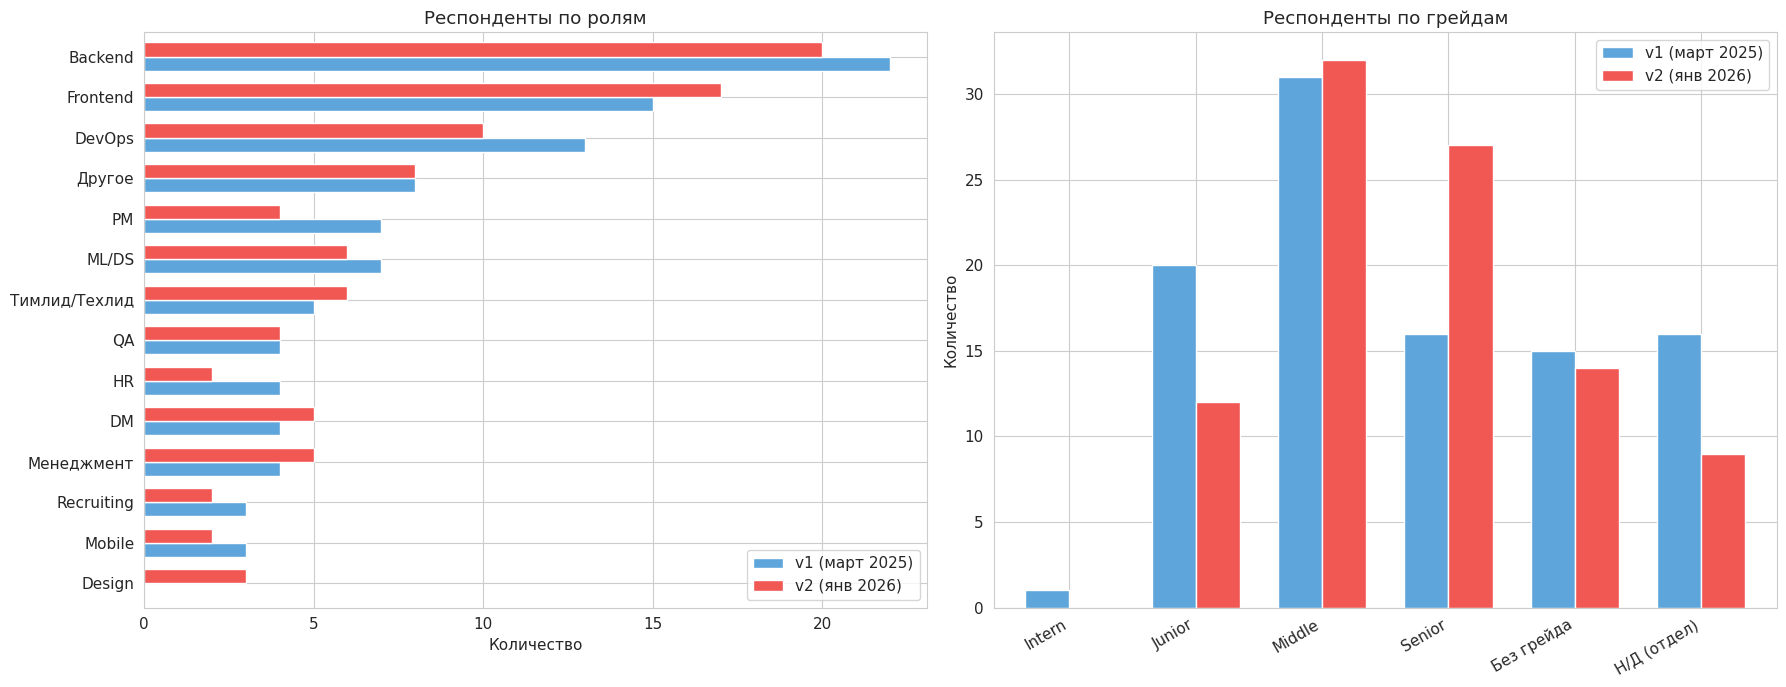

In [2]:
roles_v1 = v1['role'].value_counts()
roles_v2 = v2['role'].value_counts()
all_roles = sorted(set(roles_v1.index) | set(roles_v2.index), key=lambda r: -(roles_v1.get(r, 0) + roles_v2.get(r, 0)))
comp_roles = pd.DataFrame({
    'v1 (март 2025)': [roles_v1.get(r, 0) for r in all_roles],
    'v2 (янв 2026)': [roles_v2.get(r, 0) for r in all_roles],
}, index=all_roles)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

comp_roles.sort_values('v1 (март 2025)').plot.barh(ax=axes[0], color=C_PAIR, width=0.7)
axes[0].set_title('Респонденты по ролям')
axes[0].set_xlabel('Количество')
axes[0].legend(loc='lower right')

grades_v1 = v1['grade'].value_counts()
grades_v2 = v2['grade'].value_counts()
all_grades = [g for g in GRADE_ORDER if g in set(grades_v1.index) | set(grades_v2.index)]
comp_grades = pd.DataFrame({
    'v1 (март 2025)': [grades_v1.get(g, 0) for g in all_grades],
    'v2 (янв 2026)': [grades_v2.get(g, 0) for g in all_grades],
}, index=all_grades)

comp_grades.plot.bar(ax=axes[1], color=C_PAIR, width=0.7)
axes[1].set_title('Респонденты по грейдам')
axes[1].set_ylabel('Количество')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha='right')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

## 2. Частота использования ИИ: сдвиг вверх

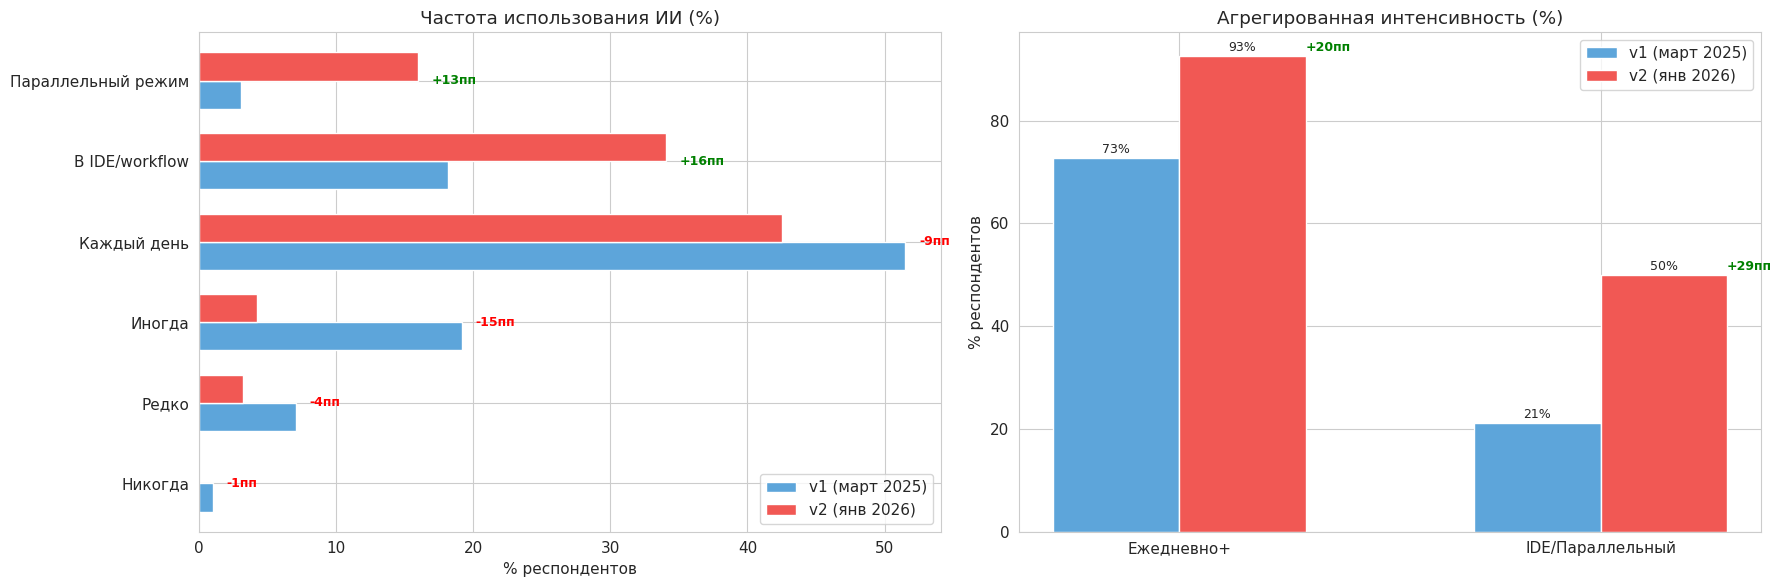

In [3]:
freq_v1 = v1['freq'].value_counts()
freq_v2 = v2['freq'].value_counts()

freq_cats = [f for f in FREQ_ORDER if f in set(freq_v1.index) | set(freq_v2.index)]
comp_freq = pd.DataFrame({
    'v1 (март 2025)': [freq_v1.get(f, 0) / len(v1) * 100 for f in freq_cats],
    'v2 (янв 2026)': [freq_v2.get(f, 0) / len(v2) * 100 for f in freq_cats],
}, index=freq_cats)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

comp_freq.plot.barh(ax=axes[0], color=C_PAIR, width=0.7)
axes[0].set_title('Частота использования ИИ (%)')
axes[0].set_xlabel('% респондентов')
axes[0].legend(loc='lower right')
for i, (v1_val, v2_val) in enumerate(zip(comp_freq['v1 (март 2025)'], comp_freq['v2 (янв 2026)'])):
    maxv = max(v1_val, v2_val)
    diff = v2_val - v1_val
    sign = '+' if diff > 0 else ''
    if abs(diff) > 0.5:
        axes[0].text(maxv + 1, i, f'{sign}{diff:.0f}пп', va='center', fontsize=9,
                     fontweight='bold', color='green' if diff > 0 else 'red')

freq_intense_v1 = (freq_v1.get('В IDE/workflow', 0) + freq_v1.get('Параллельный режим', 0)) / len(v1) * 100
freq_intense_v2 = (freq_v2.get('В IDE/workflow', 0) + freq_v2.get('Параллельный режим', 0)) / len(v2) * 100
freq_daily_v1 = sum(freq_v1.get(f, 0) for f in ['Каждый день', 'В IDE/workflow', 'Параллельный режим']) / len(v1) * 100
freq_daily_v2 = sum(freq_v2.get(f, 0) for f in ['Каждый день', 'В IDE/workflow', 'Параллельный режим']) / len(v2) * 100

summary_data = pd.DataFrame({
    'v1': [freq_daily_v1, freq_intense_v1],
    'v2': [freq_daily_v2, freq_intense_v2],
}, index=['Ежедневно+', 'IDE/Параллельный'])
summary_data['delta'] = summary_data['v2'] - summary_data['v1']

x = np.arange(len(summary_data))
w = 0.3
axes[1].bar(x - w/2, summary_data['v1'], w, label='v1 (март 2025)', color=C_V1)
axes[1].bar(x + w/2, summary_data['v2'], w, label='v2 (янв 2026)', color=C_V2)
axes[1].set_title('Агрегированная интенсивность (%)')
axes[1].set_ylabel('% респондентов')
axes[1].set_xticks(x)
axes[1].set_xticklabels(summary_data.index)
axes[1].legend()
for i, row in enumerate(summary_data.itertuples()):
    axes[1].text(i - w/2, row.v1 + 1, f'{row.v1:.0f}%', ha='center', fontsize=9)
    axes[1].text(i + w/2, row.v2 + 1, f'{row.v2:.0f}%', ha='center', fontsize=9)
    sign = '+' if row.delta > 0 else ''
    axes[1].text(i + w/2 + 0.15, row.v2 + 1, f'{sign}{row.delta:.0f}пп',
                 ha='left', fontsize=9, fontweight='bold', color='green' if row.delta > 0 else 'red')

plt.tight_layout()
plt.show()

## 3. Индивидуальная динамика (60 повторных респондентов)

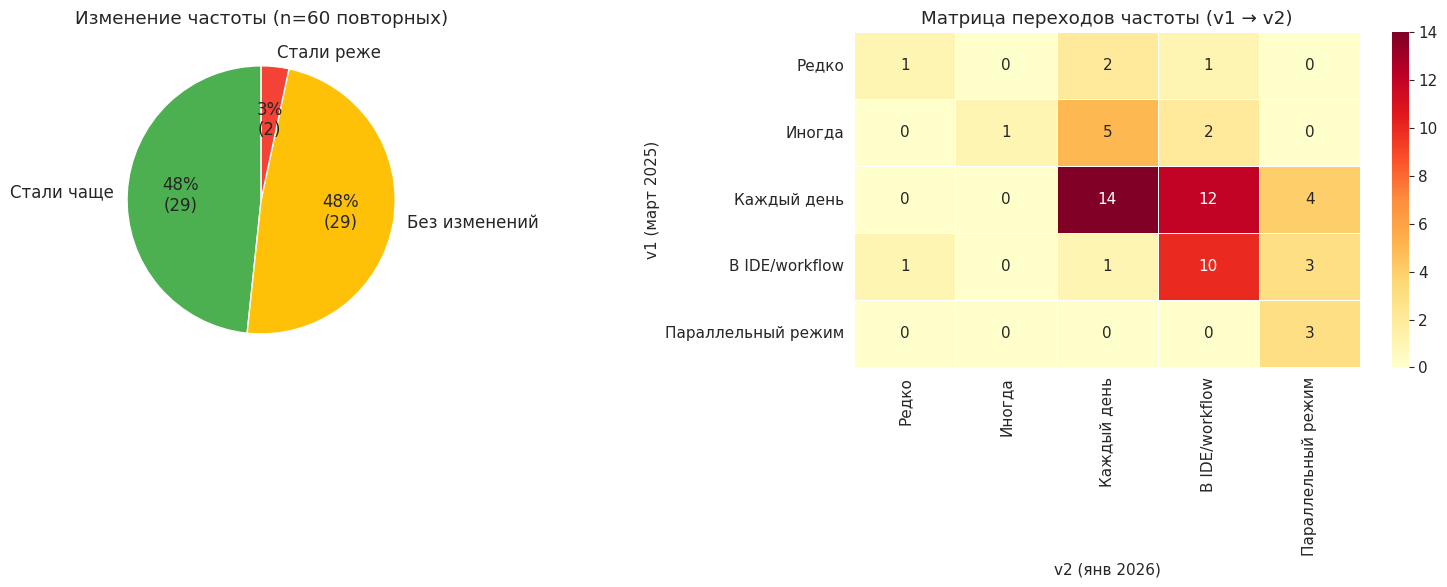

Средний сдвиг по шкале: +0.58 (шкала 0-5)


In [4]:
FREQ_RANK = {'Никогда': 0, 'Редко': 1, 'Иногда': 2, 'Каждый день': 3, 'В IDE/workflow': 4, 'Параллельный режим': 5}

v1_freq_map = v1_overlap.set_index('email')['freq']
v2_freq_map = v2_overlap.set_index('email')['freq']

transitions = []
for email in overlap_emails:
    f1 = v1_freq_map.get(email)
    f2 = v2_freq_map.get(email)
    if pd.notna(f1) and pd.notna(f2):
        r1 = FREQ_RANK.get(f1, -1)
        r2 = FREQ_RANK.get(f2, -1)
        if r1 >= 0 and r2 >= 0:
            transitions.append({'email': email, 'v1': f1, 'v2': f2, 'r1': r1, 'r2': r2, 'delta': r2 - r1})

trans_df = pd.DataFrame(transitions)
up = (trans_df['delta'] > 0).sum()
same = (trans_df['delta'] == 0).sum()
down = (trans_df['delta'] < 0).sum()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

labels = ['Стали чаще', 'Без изменений', 'Стали реже']
sizes = [up, same, down]
colors_pie = ['#4CAF50', '#FFC107', '#F44336']
axes[0].pie(sizes, labels=labels, autopct=lambda p: f'{p:.0f}%\n({int(round(p*len(trans_df)/100))})',
            startangle=90, colors=colors_pie, textprops={'fontsize': 12})
axes[0].set_title(f'Изменение частоты (n={len(trans_df)} повторных)')

freq_active = [f for f in FREQ_ORDER if f != 'Никогда']
trans_matrix = pd.DataFrame(0, index=freq_active, columns=freq_active)
for _, r in trans_df.iterrows():
    if r['v1'] in trans_matrix.index and r['v2'] in trans_matrix.columns:
        trans_matrix.loc[r['v1'], r['v2']] += 1
trans_matrix = trans_matrix.loc[trans_matrix.sum(axis=1) > 0, trans_matrix.sum(axis=0) > 0]

sns.heatmap(trans_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1], linewidths=0.5)
axes[1].set_title('Матрица переходов частоты (v1 → v2)')
axes[1].set_ylabel('v1 (март 2025)')
axes[1].set_xlabel('v2 (янв 2026)')

plt.tight_layout()
plt.show()

print(f'Средний сдвиг по шкале: {trans_df["delta"].mean():+.2f} (шкала 0-5)')

## 4. Польза от ИИ: v1 vs v2

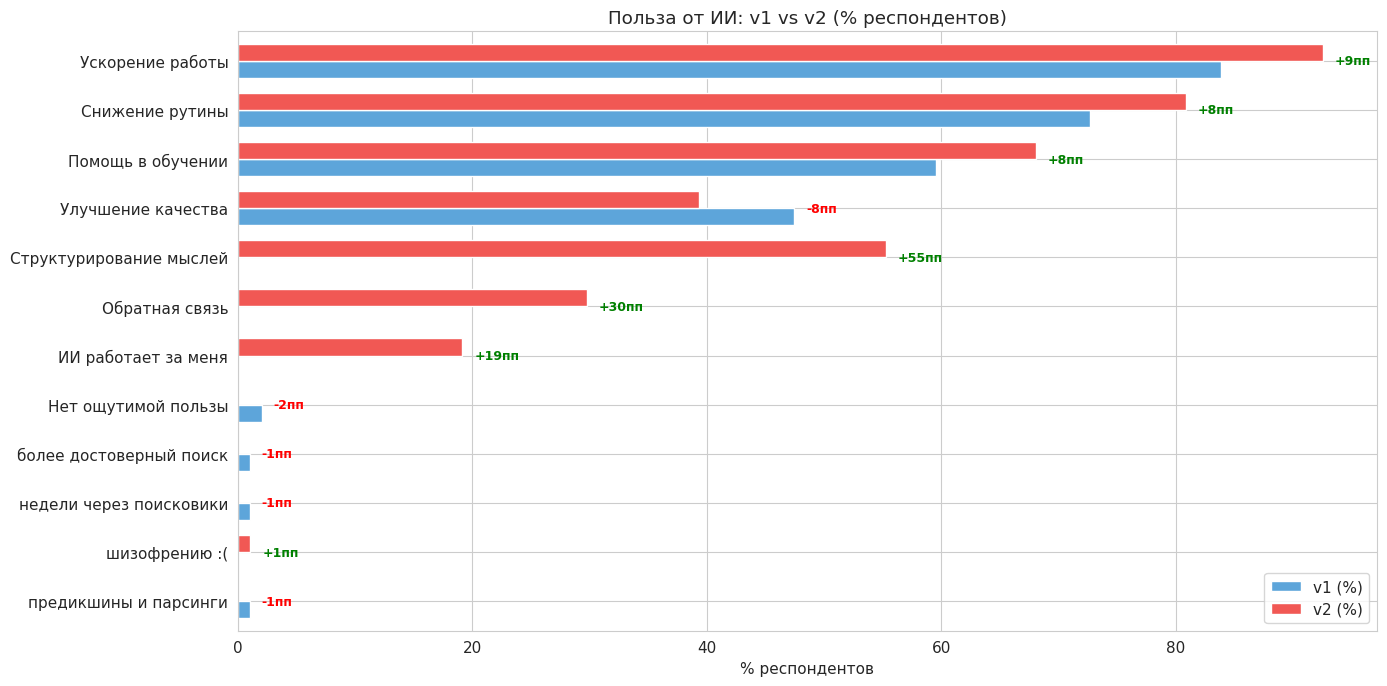

In [5]:
ben_v1 = parse_benefits(v1.iloc[:, 8])
ben_v2 = parse_benefits(v2.iloc[:, 9])

all_benefits = sorted(set(ben_v1.keys()) | set(ben_v2.keys()),
                      key=lambda b: ben_v1.get(b, 0) + ben_v2.get(b, 0))

comp_ben = pd.DataFrame({
    'v1 (%)': [ben_v1.get(b, 0) / len(v1) * 100 for b in all_benefits],
    'v2 (%)': [ben_v2.get(b, 0) / len(v2) * 100 for b in all_benefits],
}, index=all_benefits)

fig, ax = plt.subplots(figsize=(14, 7))
comp_ben.plot.barh(ax=ax, color=C_PAIR, width=0.7)
ax.set_title('Польза от ИИ: v1 vs v2 (% респондентов)')
ax.set_xlabel('% респондентов')
ax.legend(loc='lower right')

for i, b in enumerate(all_benefits):
    d = comp_ben.loc[b, 'v2 (%)'] - comp_ben.loc[b, 'v1 (%)']
    maxv = max(comp_ben.loc[b, 'v1 (%)'], comp_ben.loc[b, 'v2 (%)'])
    if abs(d) > 1:
        sign = '+' if d > 0 else ''
        ax.text(maxv + 1, i, f'{sign}{d:.0f}пп', va='center', fontsize=9,
                fontweight='bold', color='green' if d > 0 else 'red')

plt.tight_layout()
plt.show()

## 5. Ландшафт инструментов: v1 vs v2

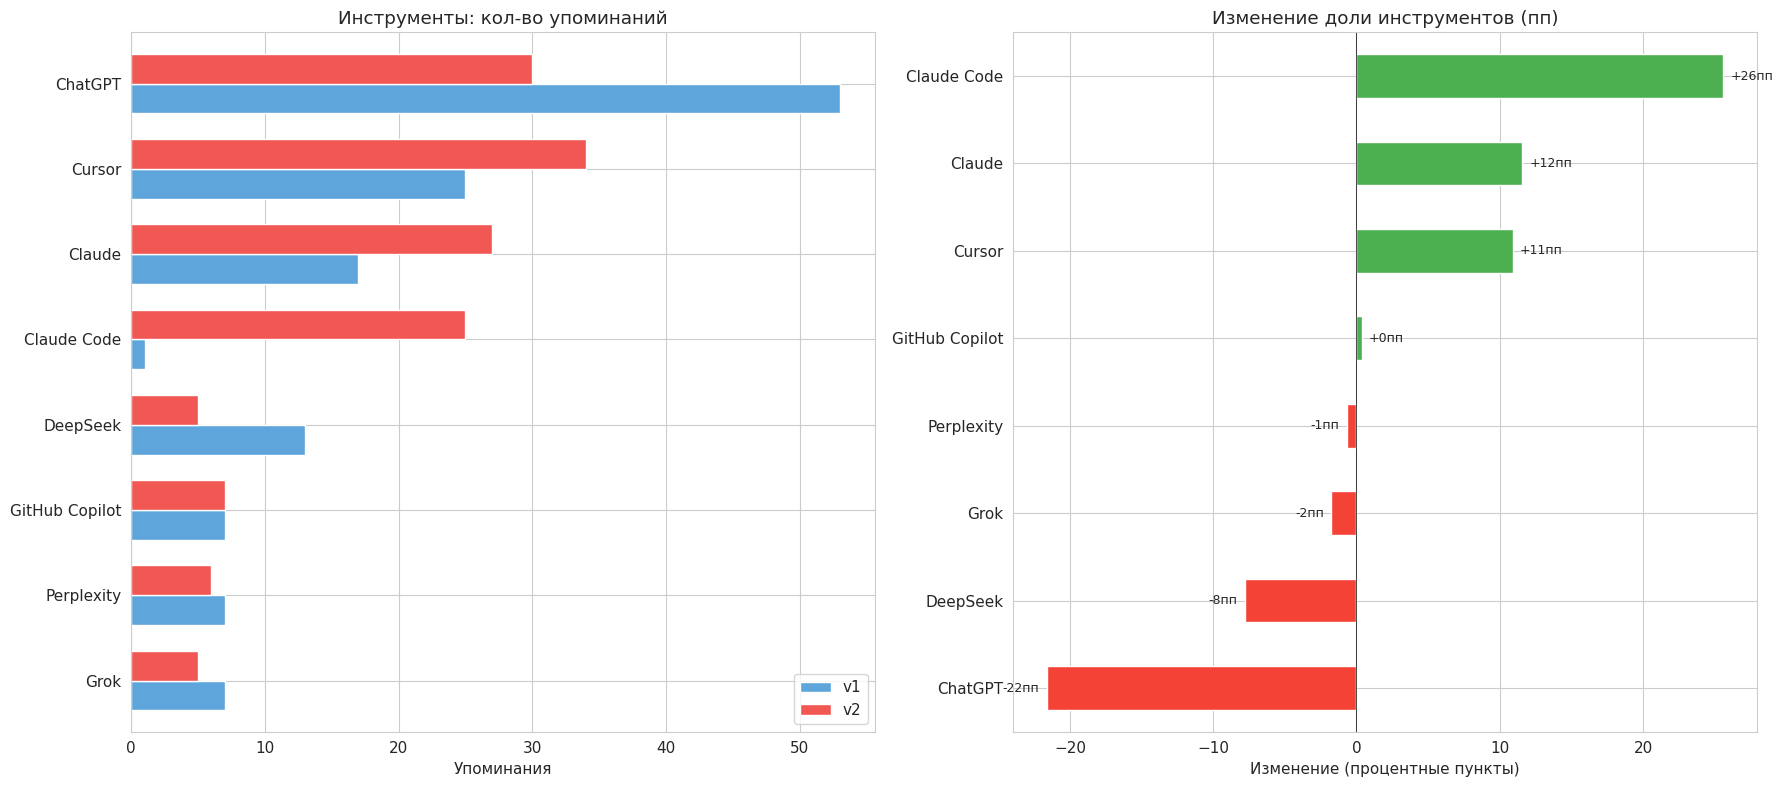

In [6]:
tools_v1_items = []
for val in v1.iloc[:, 11].dropna():
    tools_v1_items.extend(extract_tools(val))
tools_v1 = Counter(tools_v1_items)

tools_v2_items = []
for val in v2.iloc[:, 13].dropna():
    tools_v2_items.extend(extract_tools(val))
tools_v2 = Counter(tools_v2_items)

all_tools = sorted(set(tools_v1.keys()) | set(tools_v2.keys()),
                   key=lambda t: tools_v1.get(t, 0) + tools_v2.get(t, 0))
top_tools = [t for t in all_tools if tools_v1.get(t, 0) + tools_v2.get(t, 0) >= 4]

comp_tools = pd.DataFrame({
    'v1': [tools_v1.get(t, 0) for t in top_tools],
    'v2': [tools_v2.get(t, 0) for t in top_tools],
}, index=top_tools)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

comp_tools.plot.barh(ax=axes[0], color=C_PAIR, width=0.7)
axes[0].set_title('Инструменты: кол-во упоминаний')
axes[0].set_xlabel('Упоминания')
axes[0].legend(loc='lower right')

comp_tools_pct = pd.DataFrame({
    'v1 (%)': [tools_v1.get(t, 0) / len(v1) * 100 for t in top_tools],
    'v2 (%)': [tools_v2.get(t, 0) / len(v2) * 100 for t in top_tools],
}, index=top_tools)
comp_tools_pct['delta'] = comp_tools_pct['v2 (%)'] - comp_tools_pct['v1 (%)']
comp_tools_pct = comp_tools_pct.sort_values('delta')

colors_delta = [('#4CAF50' if d > 0 else '#F44336') for d in comp_tools_pct['delta']]
comp_tools_pct['delta'].plot.barh(ax=axes[1], color=colors_delta)
axes[1].set_title('Изменение доли инструментов (пп)')
axes[1].set_xlabel('Изменение (процентные пункты)')
axes[1].axvline(0, color='black', linewidth=0.5)
for i, (idx, row) in enumerate(comp_tools_pct.iterrows()):
    sign = '+' if row['delta'] > 0 else ''
    ha = 'left' if row['delta'] >= 0 else 'right'
    axes[1].text(row['delta'] + (0.5 if row['delta'] >= 0 else -0.5), i,
                 f'{sign}{row["delta"]:.0f}пп', va='center', fontsize=9, ha=ha)

plt.tight_layout()
plt.show()

## 6. Навыки промпт-инжиниринга: v1 vs v2

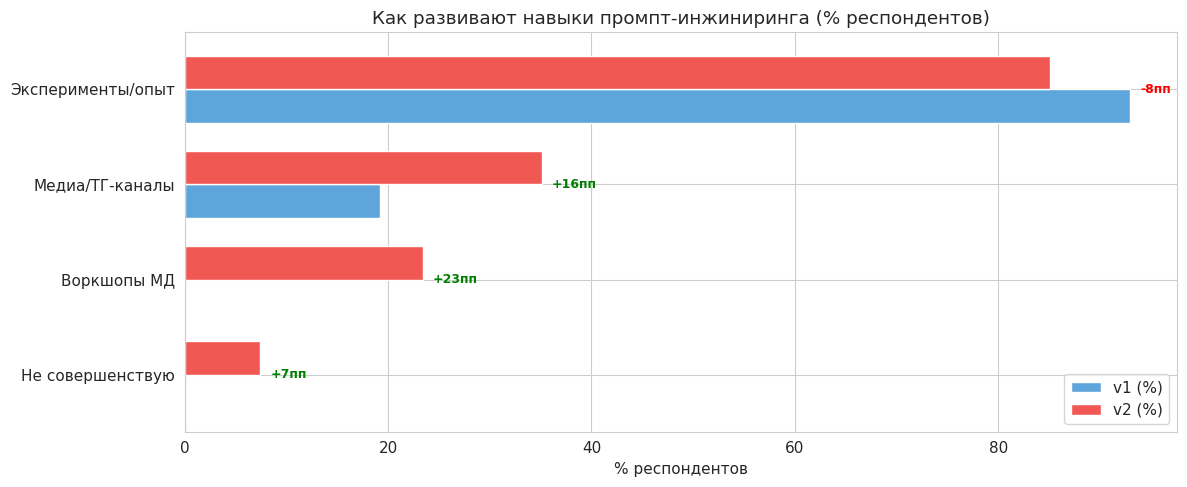

In [7]:
skills_v1 = parse_skills(v1.iloc[:, 13])
skills_v2 = parse_skills(v2.iloc[:, 14])

all_skills = sorted(set(skills_v1.keys()) | set(skills_v2.keys()),
                    key=lambda s: skills_v1.get(s, 0) + skills_v2.get(s, 0))

comp_skills = pd.DataFrame({
    'v1 (%)': [skills_v1.get(s, 0) / len(v1) * 100 for s in all_skills],
    'v2 (%)': [skills_v2.get(s, 0) / len(v2) * 100 for s in all_skills],
}, index=all_skills)

fig, ax = plt.subplots(figsize=(12, 5))
comp_skills.plot.barh(ax=ax, color=C_PAIR, width=0.7)
ax.set_title('Как развивают навыки промпт-инжиниринга (% респондентов)')
ax.set_xlabel('% респондентов')
ax.legend(loc='lower right')

for i, s in enumerate(all_skills):
    d = comp_skills.loc[s, 'v2 (%)'] - comp_skills.loc[s, 'v1 (%)']
    maxv = max(comp_skills.loc[s, 'v1 (%)'], comp_skills.loc[s, 'v2 (%)'])
    if abs(d) > 1:
        sign = '+' if d > 0 else ''
        ax.text(maxv + 1, i, f'{sign}{d:.0f}пп', va='center', fontsize=9,
                fontweight='bold', color='green' if d > 0 else 'red')

plt.tight_layout()
plt.show()

## 7. Прогноз потенциала ИИ: v1 vs v2

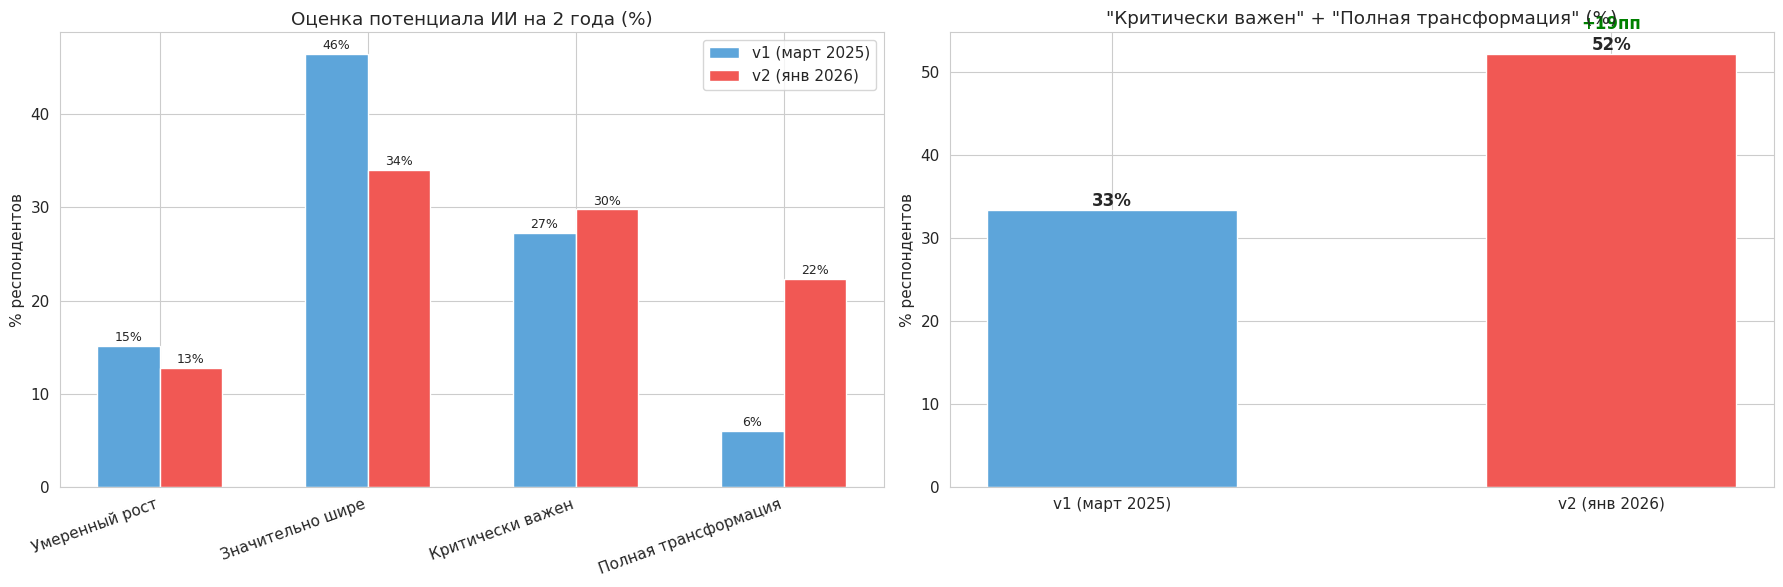

In [8]:
pot_v1 = v1['potential'].value_counts()
pot_v2 = v2['potential'].value_counts()

comp_pot = pd.DataFrame({
    'v1 (%)': [pot_v1.get(p, 0) / len(v1) * 100 for p in POTENTIAL_ORDER],
    'v2 (%)': [pot_v2.get(p, 0) / len(v2) * 100 for p in POTENTIAL_ORDER],
}, index=POTENTIAL_ORDER)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

x = np.arange(len(POTENTIAL_ORDER))
w = 0.3
axes[0].bar(x - w/2, comp_pot['v1 (%)'], w, label='v1 (март 2025)', color=C_V1)
axes[0].bar(x + w/2, comp_pot['v2 (%)'], w, label='v2 (янв 2026)', color=C_V2)
axes[0].set_title('Оценка потенциала ИИ на 2 года (%)')
axes[0].set_ylabel('% респондентов')
axes[0].set_xticks(x)
axes[0].set_xticklabels(POTENTIAL_ORDER, rotation=20, ha='right')
axes[0].legend()
for i, p in enumerate(POTENTIAL_ORDER):
    v1v = comp_pot.loc[p, 'v1 (%)']
    v2v = comp_pot.loc[p, 'v2 (%)']
    axes[0].text(i - w/2, v1v + 0.5, f'{v1v:.0f}%', ha='center', fontsize=9)
    axes[0].text(i + w/2, v2v + 0.5, f'{v2v:.0f}%', ha='center', fontsize=9)

crit_v1 = (pot_v1.get('Критически важен', 0) + pot_v1.get('Полная трансформация', 0)) / len(v1) * 100
crit_v2 = (pot_v2.get('Критически важен', 0) + pot_v2.get('Полная трансформация', 0)) / len(v2) * 100

labels = ['v1 (март 2025)', 'v2 (янв 2026)']
vals = [crit_v1, crit_v2]
bars = axes[1].bar(labels, vals, color=C_PAIR, width=0.5)
axes[1].set_title('"Критически важен" + "Полная трансформация" (%)')
axes[1].set_ylabel('% респондентов')
for bar, val in zip(bars, vals):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{val:.0f}%',
                 ha='center', fontsize=12, fontweight='bold')
diff = crit_v2 - crit_v1
axes[1].text(1, crit_v2 + 3, f'+{diff:.0f}пп', ha='center', fontsize=12,
             fontweight='bold', color='green')

plt.tight_layout()
plt.show()

## 8. Индивидуальная динамика прогноза (повторные респонденты)

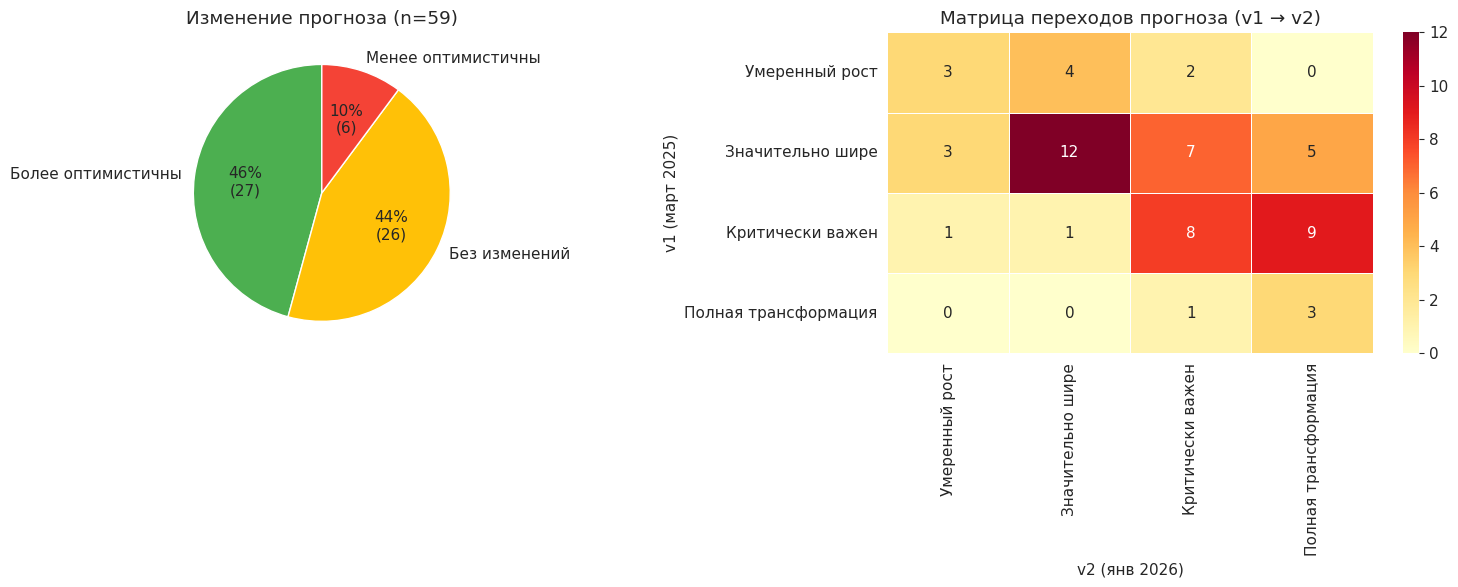

Средний сдвиг оптимизма: +0.46 (шкала 0-3)


In [9]:
POT_RANK = {p: i for i, p in enumerate(POTENTIAL_ORDER)}

v1_pot_map = v1_overlap.set_index('email')['potential']
v2_pot_map = v2_overlap.set_index('email')['potential']

pot_transitions = []
for email in overlap_emails:
    p1 = v1_pot_map.get(email)
    p2 = v2_pot_map.get(email)
    if pd.notna(p1) and pd.notna(p2) and p1 in POT_RANK and p2 in POT_RANK:
        pot_transitions.append({'v1': p1, 'v2': p2, 'delta': POT_RANK[p2] - POT_RANK[p1]})

pot_trans_df = pd.DataFrame(pot_transitions)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

up = (pot_trans_df['delta'] > 0).sum()
same = (pot_trans_df['delta'] == 0).sum()
down = (pot_trans_df['delta'] < 0).sum()
axes[0].pie([up, same, down], labels=['Более оптимистичны', 'Без изменений', 'Менее оптимистичны'],
            autopct=lambda p: f'{p:.0f}%\n({int(round(p*len(pot_trans_df)/100))})',
            startangle=90, colors=['#4CAF50', '#FFC107', '#F44336'], textprops={'fontsize': 11})
axes[0].set_title(f'Изменение прогноза (n={len(pot_trans_df)})')

pot_matrix = pd.DataFrame(0, index=POTENTIAL_ORDER, columns=POTENTIAL_ORDER)
for _, r in pot_trans_df.iterrows():
    pot_matrix.loc[r['v1'], r['v2']] += 1
pot_matrix = pot_matrix.loc[pot_matrix.sum(axis=1) > 0, pot_matrix.sum(axis=0) > 0]

sns.heatmap(pot_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1], linewidths=0.5)
axes[1].set_title('Матрица переходов прогноза (v1 → v2)')
axes[1].set_ylabel('v1 (март 2025)')
axes[1].set_xlabel('v2 (янв 2026)')

plt.tight_layout()
plt.show()

print(f'Средний сдвиг оптимизма: {pot_trans_df["delta"].mean():+.2f} (шкала 0-3)')

## 9. Частота по ролям: v1 vs v2

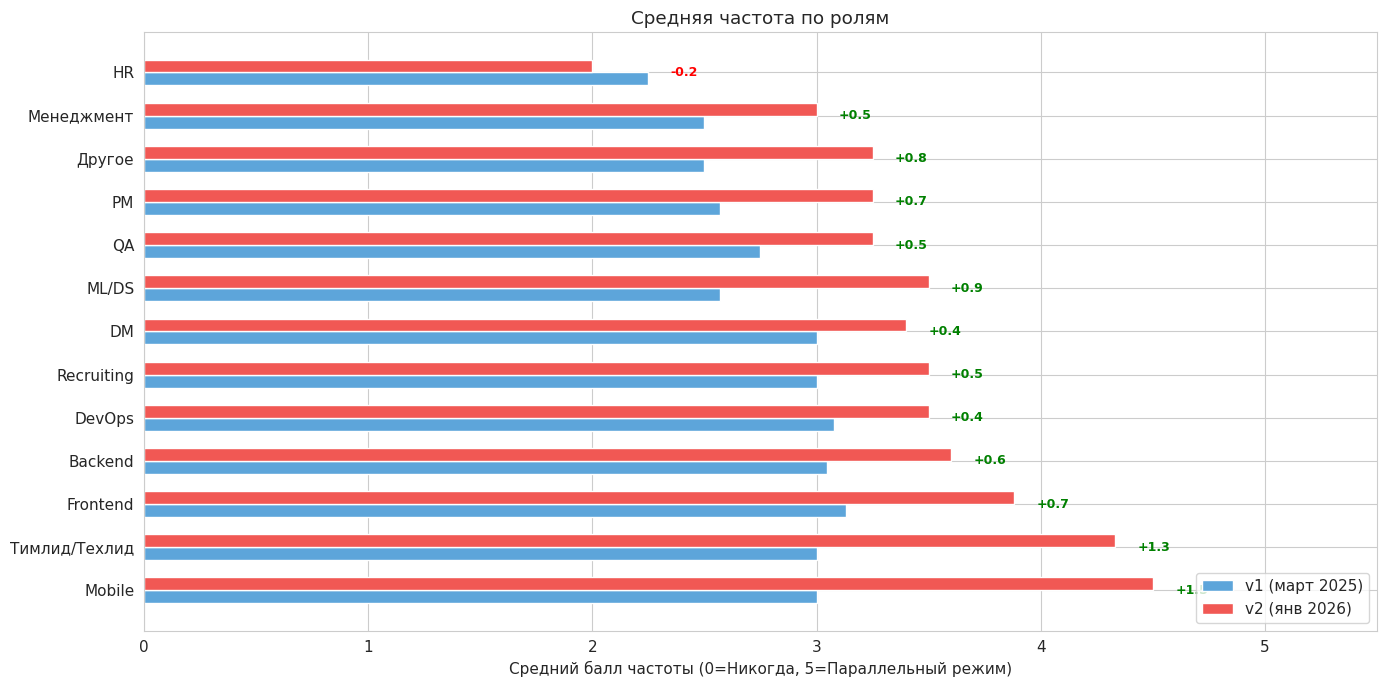

In [10]:
FREQ_SCORE = {'Никогда': 0, 'Редко': 1, 'Иногда': 2, 'Каждый день': 3, 'В IDE/workflow': 4, 'Параллельный режим': 5}

v1['freq_score'] = v1['freq'].map(FREQ_SCORE)
v2['freq_score'] = v2['freq'].map(FREQ_SCORE)

common_roles = sorted(
    set(v1['role'].unique()) & set(v2['role'].unique()),
    key=lambda r: -(v1[v1['role']==r]['freq_score'].mean() + v2[v2['role']==r]['freq_score'].mean())
)

avg_v1 = [v1[v1['role']==r]['freq_score'].mean() for r in common_roles]
avg_v2 = [v2[v2['role']==r]['freq_score'].mean() for r in common_roles]

fig, ax = plt.subplots(figsize=(14, 7))
y = np.arange(len(common_roles))
h = 0.3
ax.barh(y - h/2, avg_v1, h, label='v1 (март 2025)', color=C_V1)
ax.barh(y + h/2, avg_v2, h, label='v2 (янв 2026)', color=C_V2)
ax.set_yticks(y)
ax.set_yticklabels(common_roles)
ax.set_xlabel('Средний балл частоты (0=Никогда, 5=Параллельный режим)')
ax.set_title('Средняя частота по ролям')
ax.legend(loc='lower right')
ax.set_xlim(0, 5.5)

for i, (a1, a2) in enumerate(zip(avg_v1, avg_v2)):
    d = a2 - a1
    sign = '+' if d > 0 else ''
    maxv = max(a1, a2)
    ax.text(maxv + 0.1, i, f'{sign}{d:.1f}', va='center', fontsize=9,
            fontweight='bold', color='green' if d > 0 else ('red' if d < 0 else 'gray'))

plt.tight_layout()
plt.show()

## 10. Частота по грейдам: v1 vs v2

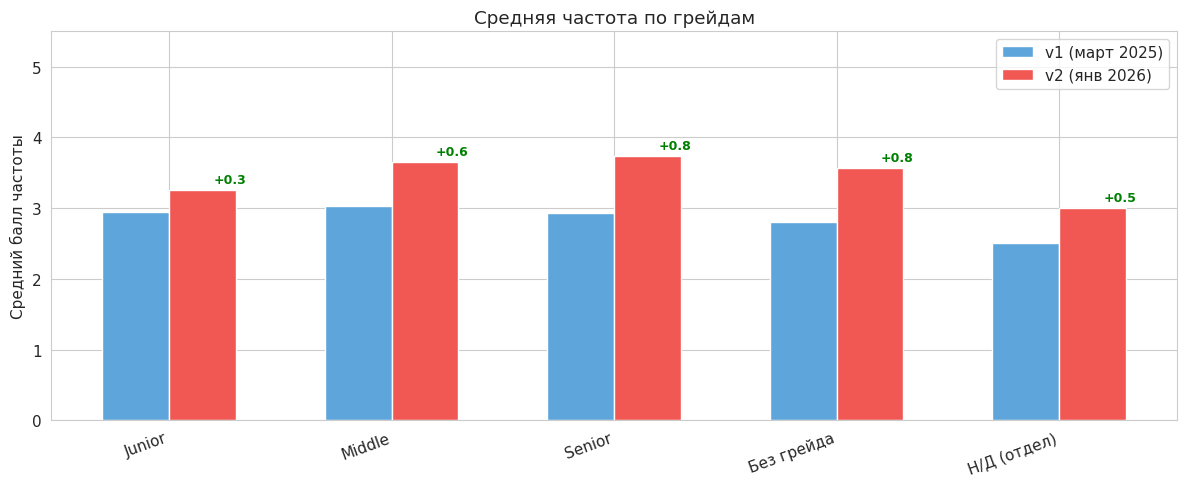

In [11]:
common_grades = [g for g in GRADE_ORDER if g in set(v1['grade'].unique()) & set(v2['grade'].unique())]

avg_v1_g = [v1[v1['grade']==g]['freq_score'].mean() for g in common_grades]
avg_v2_g = [v2[v2['grade']==g]['freq_score'].mean() for g in common_grades]

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(common_grades))
w = 0.3
ax.bar(x - w/2, avg_v1_g, w, label='v1 (март 2025)', color=C_V1)
ax.bar(x + w/2, avg_v2_g, w, label='v2 (янв 2026)', color=C_V2)
ax.set_xticks(x)
ax.set_xticklabels(common_grades, rotation=20, ha='right')
ax.set_ylabel('Средний балл частоты')
ax.set_title('Средняя частота по грейдам')
ax.legend()
ax.set_ylim(0, 5.5)

for i, (a1, a2) in enumerate(zip(avg_v1_g, avg_v2_g)):
    d = a2 - a1
    sign = '+' if d > 0 else ''
    ax.text(i + w/2 + 0.05, a2 + 0.1, f'{sign}{d:.1f}', ha='left', fontsize=9,
            fontweight='bold', color='green' if d > 0 else ('red' if d < 0 else 'gray'))

plt.tight_layout()
plt.show()

## 11. Сводная таблица изменений

In [12]:
from IPython.display import Markdown, display

daily_v1 = sum(freq_v1.get(f, 0) for f in ['Каждый день', 'В IDE/workflow', 'Параллельный режим'])
daily_v2 = sum(freq_v2.get(f, 0) for f in ['Каждый день', 'В IDE/workflow', 'Параллельный режим'])
daily_v1_pct = daily_v1 / len(v1) * 100
daily_v2_pct = daily_v2 / len(v2) * 100

ide_v1 = (freq_v1.get('В IDE/workflow', 0) + freq_v1.get('Параллельный режим', 0)) / len(v1) * 100
ide_v2 = (freq_v2.get('В IDE/workflow', 0) + freq_v2.get('Параллельный режим', 0)) / len(v2) * 100

top_tool_v1 = max(tools_v1, key=tools_v1.get) if tools_v1 else 'N/A'
top_tool_v2 = max(tools_v2, key=tools_v2.get) if tools_v2 else 'N/A'

crit_v1_n = pot_v1.get('Критически важен', 0) + pot_v1.get('Полная трансформация', 0)
crit_v2_n = pot_v2.get('Критически важен', 0) + pot_v2.get('Полная трансформация', 0)
crit_v1_pct = crit_v1_n / len(v1) * 100
crit_v2_pct = crit_v2_n / len(v2) * 100

def arrow(d):
    if d > 1: return f'+{d:.0f}пп ↑'
    elif d < -1: return f'{d:.0f}пп ↓'
    else: return '≈'

summary = f"""### Сводка изменений: v1 (март 2025) → v2 (январь 2026)

| Метрика | v1 ({len(v1)} чел.) | v2 ({len(v2)} чел.) | Δ |
|---|---|---|---|
| Используют ежедневно+ | {daily_v1_pct:.0f}% | {daily_v2_pct:.0f}% | **{arrow(daily_v2_pct - daily_v1_pct)}** |
| IDE/Параллельный режим | {ide_v1:.0f}% | {ide_v2:.0f}% | **{arrow(ide_v2 - ide_v1)}** |
| Топ инструмент | {top_tool_v1} | {top_tool_v2} | — |
| "Критически важен" + "Трансформация" | {crit_v1_pct:.0f}% | {crit_v2_pct:.0f}% | **{arrow(crit_v2_pct - crit_v1_pct)}** |
| Повторных респондентов | — | — | **{len(overlap_emails)}** |
| Из повторных: стали чаще | — | — | **{up}** из {len(trans_df)} ({up/len(trans_df)*100:.0f}%) |
| Из повторных: более оптимистичны | — | — | **{(pot_trans_df['delta'] > 0).sum()}** из {len(pot_trans_df)} ({(pot_trans_df['delta'] > 0).sum()/len(pot_trans_df)*100:.0f}%) |

---

### Главные тренды

1. **Глубже интегрируют ИИ**: доля "В IDE/параллельный режим" выросла с {ide_v1:.0f}% до {ide_v2:.0f}% — сотрудники переходят от разовых запросов к постоянной интеграции.

2. **Категория "Иногда" почти исчезла**: c {freq_v1.get('Иногда', 0)/len(v1)*100:.0f}% до {freq_v2.get('Иногда', 0)/len(v2)*100:.0f}% — те, кто раньше использовал ИИ эпизодически, перешли к ежедневному использованию.

3. **Рост оптимизма**: "Полная трансформация" выросла с {pot_v1.get('Полная трансформация', 0)/len(v1)*100:.0f}% до {pot_v2.get('Полная трансформация', 0)/len(v2)*100:.0f}% — в 3.5 раза больше людей ожидают полной трансформации профессии.

4. **Claude Code — новый лидер**: появился как отдельный инструмент и быстро набрал популярность. Cursor также растёт.

5. **Ускорение работы по-прежнему #1**: остаётся главным бенефитом, но "структурирование мыслей" и "обратная связь" набирают вес.

6. **Воркшопы МД заметны**: в v2 значительно больше людей указывают воркшопы как способ развития промпт-навыков.

---

### Рекомендации на основе динамики

1. **Фокус на продвинутые сценарии** — базовый уровень уже достигнут, нужны воркшопы по IDE-интеграции и агентным workflow.
2. **Масштабировать то, что работает** — воркшопы дают эффект, увеличить частоту.
3. **Стандартизировать стек** — Claude/Claude Code + Cursor покрывают большинство потребностей.
4. **Подготовка к трансформации** — 52% ожидают критические изменения, компания должна быть готова.
"""

display(Markdown(summary))

### Сводка изменений: v1 (март 2025) → v2 (январь 2026)

| Метрика | v1 (99 чел.) | v2 (94 чел.) | Δ |
|---|---|---|---|
| Используют ежедневно+ | 73% | 93% | **+20пп ↑** |
| IDE/Параллельный режим | 21% | 50% | **+29пп ↑** |
| Топ инструмент | ChatGPT | Cursor | — |
| "Критически важен" + "Трансформация" | 33% | 52% | **+19пп ↑** |
| Повторных респондентов | — | — | **60** |
| Из повторных: стали чаще | — | — | **27** из 60 (45%) |
| Из повторных: более оптимистичны | — | — | **27** из 59 (46%) |

---

### Главные тренды

1. **Глубже интегрируют ИИ**: доля "В IDE/параллельный режим" выросла с 21% до 50% — сотрудники переходят от разовых запросов к постоянной интеграции.

2. **Категория "Иногда" почти исчезла**: c 19% до 4% — те, кто раньше использовал ИИ эпизодически, перешли к ежедневному использованию.

3. **Рост оптимизма**: "Полная трансформация" выросла с 6% до 22% — в 3.5 раза больше людей ожидают полной трансформации профессии.

4. **Claude Code — новый лидер**: появился как отдельный инструмент и быстро набрал популярность. Cursor также растёт.

5. **Ускорение работы по-прежнему #1**: остаётся главным бенефитом, но "структурирование мыслей" и "обратная связь" набирают вес.

6. **Воркшопы МД заметны**: в v2 значительно больше людей указывают воркшопы как способ развития промпт-навыков.

---

### Рекомендации на основе динамики

1. **Фокус на продвинутые сценарии** — базовый уровень уже достигнут, нужны воркшопы по IDE-интеграции и агентным workflow.
2. **Масштабировать то, что работает** — воркшопы дают эффект, увеличить частоту.
3. **Стандартизировать стек** — Claude/Claude Code + Cursor покрывают большинство потребностей.
4. **Подготовка к трансформации** — 52% ожидают критические изменения, компания должна быть готова.
